In [515]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [516]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [517]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current


,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,dt,dates,h_date,h_time
0,18.63,18.01,16.60,18.63,1017,1017,1008,56,2.03,1710957600,2024-03-20 19:00:00,20/03/2024 19:00:00,19
1,16.47,15.87,14.89,16.47,1019,1019,1010,65,1.58,1710968400,2024-03-20 22:00:00,20/03/2024 22:00:00,22
2,14.13,13.45,14.13,14.13,1021,1021,1012,71,0.00,1710979200,2024-03-21 01:00:00,21/03/2024 01:00:00,01
3,12.38,11.76,12.38,12.38,1022,1022,1012,80,0.00,1710990000,2024-03-21 04:00:00,21/03/2024 04:00:00,04
4,11.15,10.46,11.15,11.15,1024,1024,1014,82,0.00,1711000800,2024-03-21 07:00:00,21/03/2024 07:00:00,07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,5.36,5.36,5.36,5.36,1014,1014,1004,79,0.00,1711335600,2024-03-25 04:00:00,25/03/2024 04:00:00,04
36,4.82,4.82,4.82,4.82,1013,1013,1003,82,0.00,1711346400,2024-03-25 07:00:00,25/03/2024 07:00:00,07
37,7.91,6.40,7.91,7.91,1011,1011,1001,67,0.00,1711357200,2024-03-25 10:00:00,25/03/2024 10:00:00,10
38,10.89,9.39,10.89,10.89,1008,1008,998,52,0.00,1711368000,2024-03-25 13:00:00,25/03/2024 13:00:00,13


In [518]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('20/03/2024 19:00:00', '25/03/2024 16:00:00')

<Axes: >

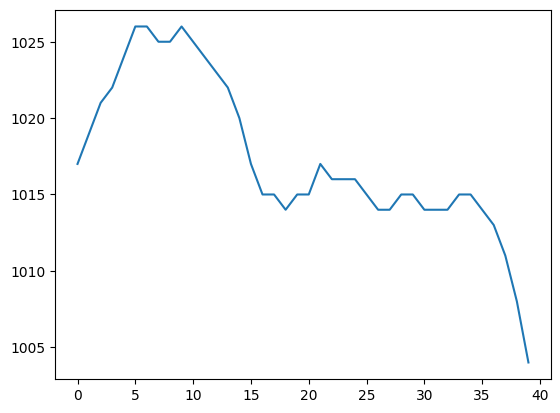

In [519]:
(current.pressure).plot()


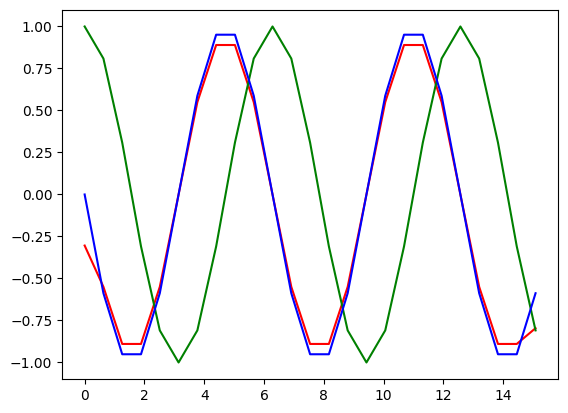

In [520]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

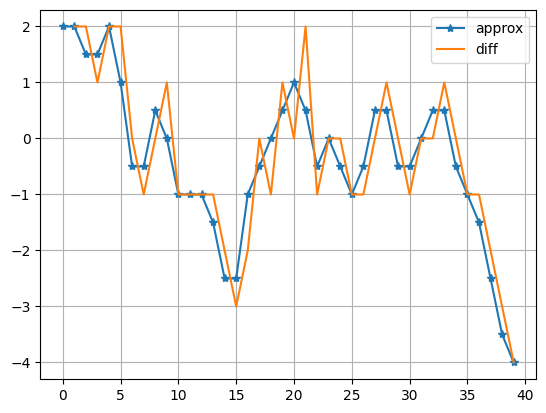

In [521]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


In [522]:
dy.diff()

0     NaN
1     2.0
2     2.0
3     1.0
4     2.0
     ... 
35   -1.0
36   -1.0
37   -2.0
38   -3.0
39   -4.0
Name: pressure, Length: 40, dtype: float64

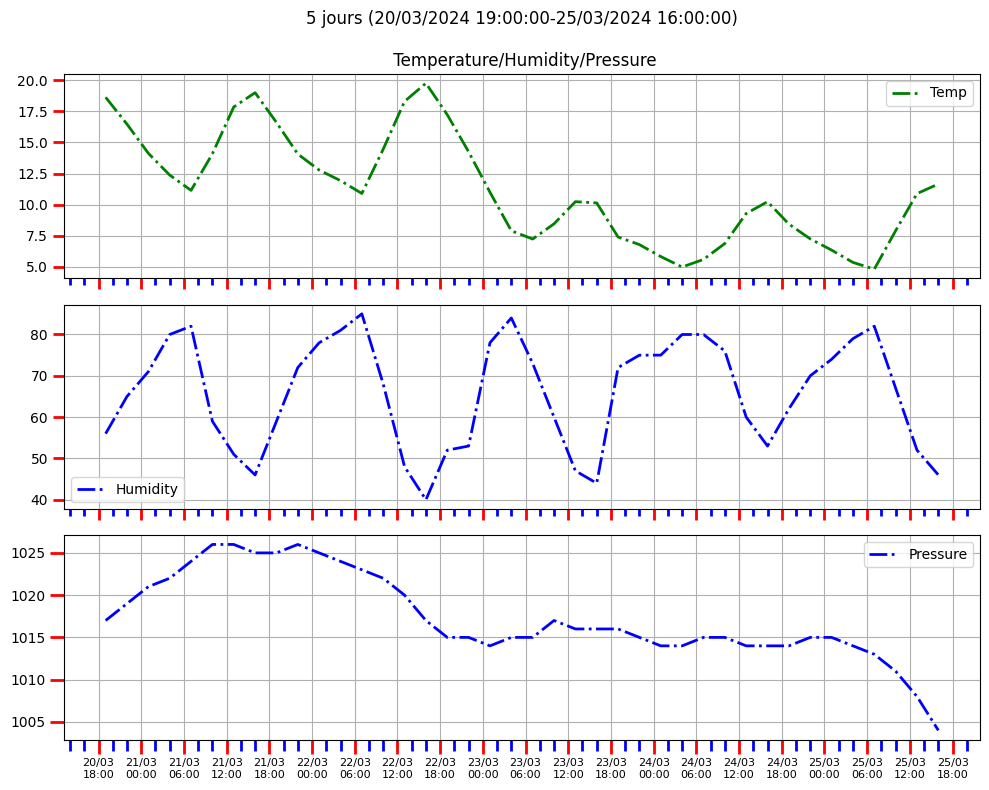

In [523]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

In [524]:
'''Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre
'''
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


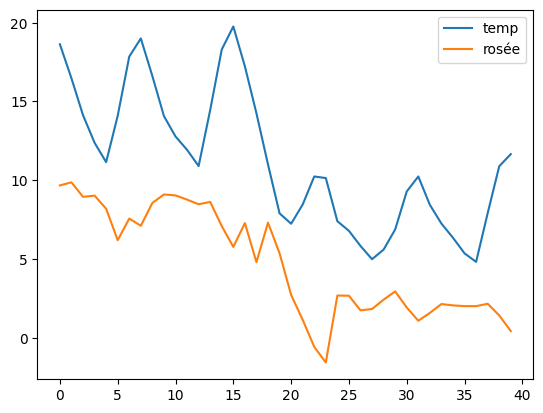

In [525]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='rosée')
plt.legend()


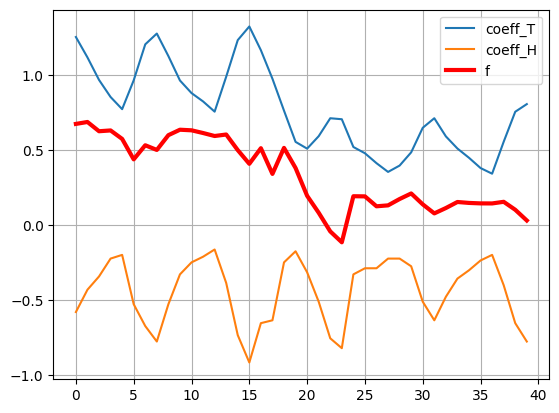

In [526]:
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha()
plt.plot(x,f,label='f',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

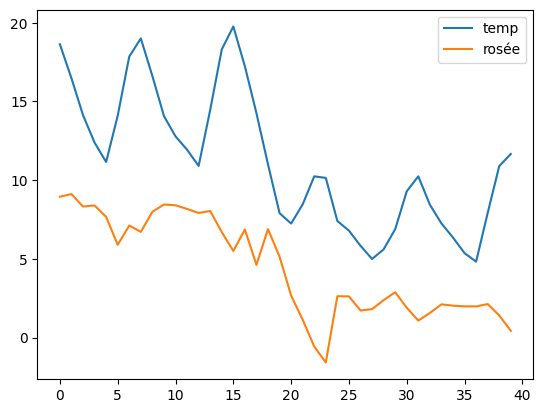

In [527]:
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a+f),label='rosée')
plt.legend()
b,a


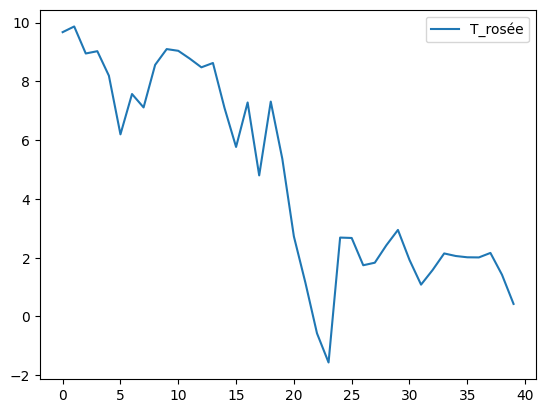

In [528]:
plt.plot(x,b*f/(a-f),label='T_rosée')
plt.legend()

In [529]:

f = y_temp+y_hum
f, alpha(y_temp,x_hum)


(0     0.675361
 1     0.688298
 2     0.626517
 3     0.631793
 4     0.575351
         ...   
 35    0.145119
 36    0.144784
 37    0.155712
 38    0.102622
 39    0.031011
 Length: 40, dtype: float64,
 0    -0.489103
 1    -0.349857
 2    -0.272373
 3    -0.161251
 4    -0.142413
         ...   
 35   -0.208097
 36   -0.173549
 37   -0.360162
 38   -0.599134
 39   -0.718056
 Length: 40, dtype: float64)

In [530]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.579818
 1    -0.430783
 2    -0.342490
 3    -0.223144
 4    -0.198451
         ...   
 35   -0.235722
 36   -0.198451
 37   -0.400478
 38   -0.653926
 39   -0.776529
 Name: humidity, Length: 40, dtype: float64)

In [531]:
dewpoint(current.temp[0],current.humidity[0]/100)

(18.63, 9.673801989838726, 8.956198010161273)

In [532]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt

(0     18.63
 1     16.47
 2     14.13
 3     12.38
 4     11.15
       ...  
 35     5.36
 36     4.82
 37     7.91
 38    10.89
 39    11.66
 Name: temp, Length: 40, dtype: float64,
 0     9.673802
 1     9.866812
 2     8.947831
 3     9.026048
 4     8.191896
         ...   
 35    2.014303
 36    2.009622
 37    2.162680
 38    1.420902
 39    0.427600
 Length: 40, dtype: float64,
 0      8.956198
 1      6.603188
 2      5.182169
 3      3.353952
 4      2.958104
         ...    
 35     3.345697
 36     2.810378
 37     5.747320
 38     9.469098
 39    11.232400
 Length: 40, dtype: float64)

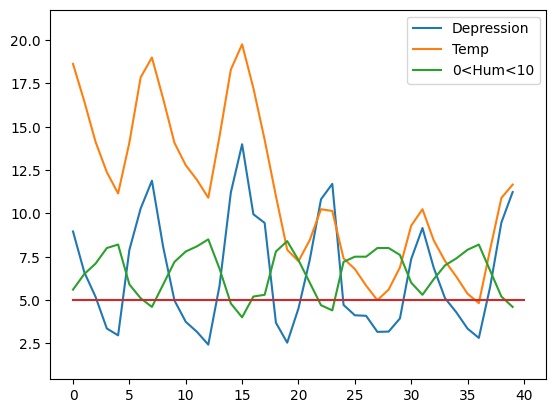

In [533]:
plt.plot(dewpt[2],label='Depression')
plt.plot(current.temp,label='Temp')
plt.plot(current.humidity/10,label='0<Hum<10')
plt.plot((0,40),(5,5))
plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
plt.legend()
plt.show()


In [534]:
current.temp.head(),current.h_time.head()

(0    18.63
 1    16.47
 2    14.13
 3    12.38
 4    11.15
 Name: temp, dtype: float64,
 0    19
 1    22
 2    01
 3    04
 4    07
 Name: h_time, dtype: object)

In [535]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,19,18.63,9.673802
1,22,16.47,9.866812
2,01,14.13,8.947831
3,04,12.38,9.026048
4,07,11.15,8.191896
...,...,...,...
35,04,5.36,2.014303
36,07,4.82,2.009622
37,10,7.91,2.162680
38,13,10.89,1.420902


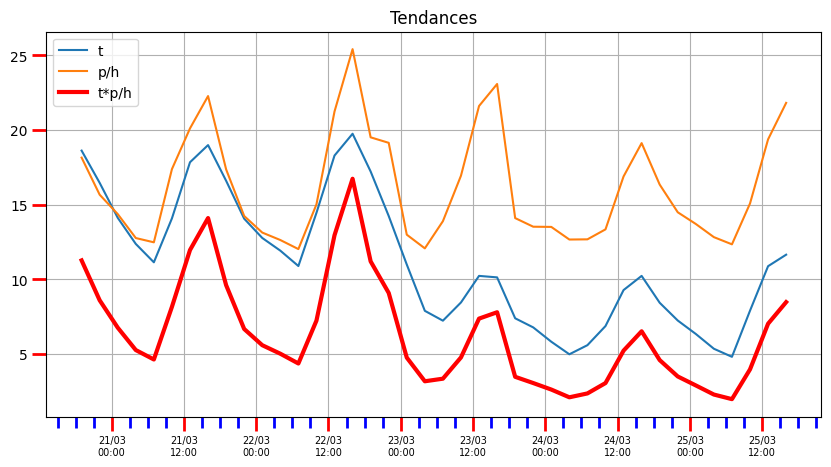

In [536]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

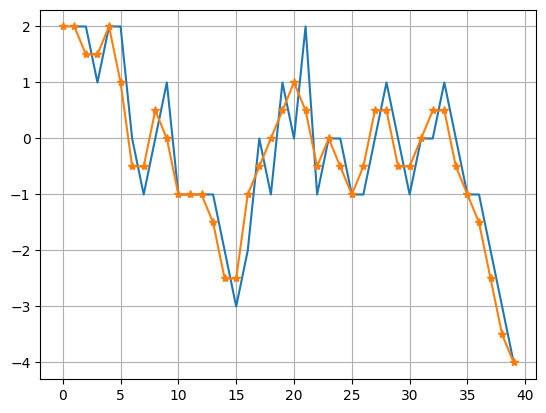

In [537]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [538]:
len(dy)

40

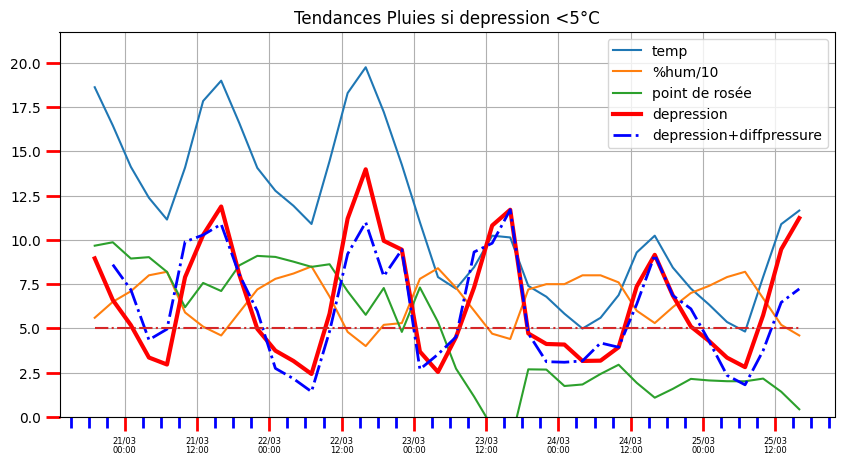

In [539]:
temp = current.temp  
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax = plt.subplots()

# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=6)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, temp,label='temp')
plt.plot(current.dates, current.humidity/10,label='%hum/10')
plt.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
plt.plot(current.dates, depression,label="depression",lw=3,c='red')
plt.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
plt.plot((current.dates[0],current.dates[39]),(5,5),'-.')

plt.ylim(0,max(current.temp)+2)
plt.legend()
plt.title('Tendances Pluies si depression <5°C')
plt.grid()


In [540]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,20/03/2024 19:00:00,18.63,8.956198,beau temps
1,20/03/2024 22:00:00,16.47,6.603188,beau temps
2,21/03/2024 01:00:00,14.13,5.182169,beau temps
3,21/03/2024 04:00:00,12.38,3.353952,pluie
4,21/03/2024 07:00:00,11.15,2.958104,pluie
5,21/03/2024 10:00:00,14.09,7.893230,beau temps
6,21/03/2024 13:00:00,17.85,10.280978,beau temps
7,21/03/2024 16:00:00,19.00,11.887630,beau temps
8,21/03/2024 19:00:00,16.61,8.049491,beau temps
9,21/03/2024 22:00:00,14.07,4.972379,pluie


In [463]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,22/03/2024 13:00:00,18.50,12.819482,beau temps
21,22/03/2024 16:00:00,20.20,16.369896,beau temps
22,22/03/2024 19:00:00,17.65,10.849188,beau temps
23,22/03/2024 22:00:00,13.87,5.381189,beau temps
24,23/03/2024 01:00:00,10.96,7.228783,beau temps
25,23/03/2024 04:00:00,9.31,2.564516,pluie
26,23/03/2024 07:00:00,7.74,1.698266,pluie
27,23/03/2024 10:00:00,7.51,2.189409,pluie
28,23/03/2024 13:00:00,10.13,10.515605,beau temps
29,23/03/2024 16:00:00,11.63,14.945085,beau temps


In [464]:
current.h_date

0     20/03/2024 01:00:00
1     20/03/2024 04:00:00
2     20/03/2024 07:00:00
3     20/03/2024 10:00:00
4     20/03/2024 13:00:00
             ...         
35    24/03/2024 10:00:00
36    24/03/2024 13:00:00
37    24/03/2024 16:00:00
38    24/03/2024 19:00:00
39    24/03/2024 22:00:00
Name: h_date, Length: 40, dtype: object